In [2]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np

images_names = [item for item in listdir('test_images/') if isfile(join('test_images/', item))]
mask_names = [item for item in listdir('test_images_mask/') if isfile(join('test_images_mask/', item))]

mask_names = [mask[:-9] for mask in mask_names]
mask_names.pop(61)

images_names = [image[:-4] for image in images_names]
images_names.pop(21)

df = pd.read_excel("metadata_with_feature_annotations.xlsx", sheet_name= 2, header=0)

own_list = df.img_id.tolist()
own_list = [image[:-4] for image in own_list]

combined_list = own_list + images_names
unique_elements = []

for element in combined_list:
    if element not in own_list or element not in images_names:
        unique_elements.append(element)

df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   img_id      93 non-null     object 
 1   color       93 non-null     float64
 2   assymmetry  93 non-null     float64
dtypes: float64(2), object(1)
memory usage: 2.3+ KB


In [2]:
df['assymmetry'] = df['assymmetry'] / 2.6

In [3]:
df['color'] = df['color'] / 0.5

In [4]:
df.color.unique()

df

,img_id,color,assymmetry
0,PAT_1516_1765_530.png,0.0,0.0
1,PAT_46_881_939.png,2.0,0.5
2,PAT_1545_1867_547.png,2.0,1.0
3,PAT_684_1302_588.png,2.0,0.0
4,PAT_1549_1882_230.png,2.0,0.5
...,...,...,...
88,PAT_430_848_476.png,3.0,1.0
89,PAT_419_832_706.png,3.0,1.0
90,PAT_1423_1472_18.png,1.0,1.0
91,PAT_55_84_506.png,3.0,0.0


In [3]:
import os

from MyModel import ProcessImages


#################
### COMSTANTS ###
#################

file_data = 'metadata_withmasks.csv'
image_folder = 'test_images' + os.sep
mask_folder = 'test_images_mask' + os.sep
file_features = 'feature_data.csv'

# ProcessImages(file_data, image_folder, mask_folder, file_features)

In [4]:
import numpy as np

# Feature extraction
from asymmetry import mean_asymmetry
from color import slic_segmentation, rgb_var, hsv_var, color_dominance
from compactness import compactness_score
from convexity import convexity_score

from prep_image import prep_im_and_mask

im, mask = prep_im_and_mask("PAT_1516_1765_530.png", image_folder, mask_folder)

def extract_features(im, im_mask):

	# Assymmetry
	asymmetry = mean_asymmetry(im_mask,4)
	print("asymmetry")

	# Color variance
	segments = slic_segmentation(im, im_mask)
	red_var, green_var, blue_var = rgb_var(im, segments)
	hue_var, sat_var, val_var = hsv_var(im, segments)

	print("CV")

	# Color dominance
	dom_colors = color_dominance(im, im_mask, clusters=5, include_ratios=True) # Extract five most dominent colors, sorted by percentage of total area
	print("1CD")
	dom_hue, dom_sat, dom_val = dom_colors[0][1]     

	print("CD")
	# Compactness
	compactness = compactness_score(im_mask)
	print("Compact")

	# Convexity
	convexity = convexity_score(im_mask)
	print("Convexity")

	return np.array([asymmetry, red_var, green_var, blue_var, \
		hue_var, sat_var, val_var, dom_hue, dom_sat, dom_val, \
		compactness, convexity], dtype=np.float16)

extract_features(im, mask)


asymmetry
CV


AttributeError: 'NoneType' object has no attribute 'split'

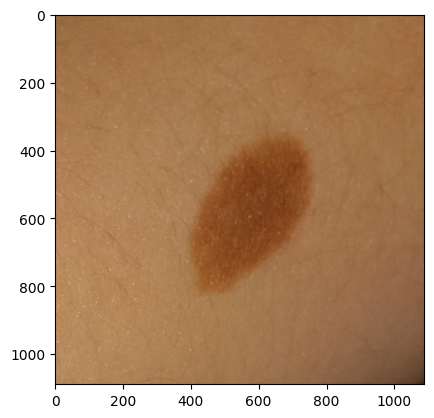

In [12]:
import matplotlib.pyplot as plt
plt.imshow(im)

In [15]:
from skimage.segmentation import slic
from skimage.color import rgb2hsv
from sklearn.cluster import KMeans
from cut import cut_im_by_mask

def col_dom(image, mask, clusters=5, include_ratios = False):
    cut_im = cut_im_by_mask(image, mask) # Cut image to remove excess skin pixels
    hsv_im = rgb2hsv(cut_im) # Convert image to HSV color space
    flat_im = np.reshape(hsv_im, (-1, 3)) # Flatten image to 2D array

    # Use KMeans to cluster image by colors
    k_means = KMeans(n_clusters=clusters, random_state=0)
    k_means.fit(flat_im)

    # Save cluster centers (dominant colors) in array
    dom_colors = np.array(k_means.cluster_centers_, dtype='float32') 

    if include_ratios:

        counts = np.unique(k_means.labels_, return_counts=True)[1] # Get count of each dominent color
        ratios = counts / flat_im.shape[0] # Get percentage of total image for each dominent color

        r_and_c = zip(ratios, dom_colors) # Percentage and colors
        r_and_c = sorted(r_and_c, reverse=True) # Sort in descending order

        return r_and_c
    
    return dom_colors

col_dom(im, mask, include_ratios = True)

[[0.08235294 0.5        0.6666667 ]
 [0.08235294 0.5        0.6666667 ]
 [0.08235295 0.49707603 0.67058825]
 ...
 [0.07831325 0.5123457  0.63529414]
 [0.07831325 0.51552796 0.6313726 ]
 [0.07613168 0.50625    0.627451  ]]


AttributeError: 'NoneType' object has no attribute 'split'